In [1]:
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.io.fits import getheader
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import mpyfit
from astropy.io import fits
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import csv
import pickle
import math as m
import pandas as pd
import os

#from master_shifting_planet import master_shifting_planet
from mu_plotting import mu_plotting
from residual_plot import residual_plot
from fwhm_sigma import fwhm_sigma
from master_shifting_EXPRES import master_shifting_EXPRES
from std import std

4.887035216762464

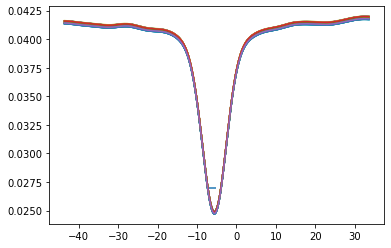

In [2]:
star_name = '101501'

ccf_file_list = os.listdir('HD'+star_name+'/CCFs '+star_name+'/')
txt_file = pd.read_csv('HD'+star_name+'/'+star_name+'_activity.csv')

ccf_list = []
V_grid_list = []
file_names_list1 = []
file_names_list2 = []

for i in np.arange(0, len(ccf_file_list)):
    hdul_open_test = fits.open('HD'+star_name+'/CCFs '+star_name+'/'+ccf_file_list[i], memmap=False)
    ccf_test = hdul_open_test[1].data['ccf']
    ccf_list.append(ccf_test)
    V_grid = hdul_open_test[1].data['V_grid']*1e-5 #km/s
    V_grid_list.append(V_grid)
    file_name1 = ccf_file_list[i].split('_ccf.')[0]
    file_names_list1.append(file_name1)
    
    file_name2 = txt_file["File"][i].split('.fi')[0]
    file_names_list2.append(file_name2)

    
s_pd_ccfs = pd.DataFrame(list(zip(file_names_list1, ccf_list, V_grid_list)), 
               columns =['filenames', 'ccf', 'wls'])
s_pd_ccfs_sorted = s_pd_ccfs.sort_values(by=['filenames'])  

offset = txt_file["CBC RV [m/s]"][0]-txt_file["CCF RV [m/s]"][0]

s_pd_rv_info = pd.DataFrame(list(zip(file_names_list2, txt_file["CCF RV [m/s]"]-offset,
                                     txt_file["CCF RV Err. [m/s]"], txt_file["Time [MJD]"], txt_file["CCF FWHM [m/s]"])), 
               columns =['filenames', 'RV', "RV_e", "BJD", "fwhm"])
s_pd_rv_info_sorted = s_pd_rv_info.sort_values(by=['filenames']) 

combined_df = pd.DataFrame(list(zip(s_pd_ccfs_sorted['filenames'],
                                    s_pd_rv_info_sorted["filenames"], 
                                    s_pd_rv_info_sorted["BJD"],
                                    s_pd_ccfs_sorted['ccf'],
                                    s_pd_ccfs_sorted['wls'],
                                    s_pd_rv_info_sorted["RV"],
                                    s_pd_rv_info_sorted["RV_e"],
                                    s_pd_rv_info_sorted["fwhm"])), 
               columns =['filenames_ccf','filenames2',"bjd", 'ccf','wls','vrad', "svrad", "fwhm"])
#fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for i in ccf_list:
    plt.plot(s_pd_ccfs_sorted['wls'][0],i)

plt.hlines(0.027, s_pd_ccfs_sorted['wls'][0][367], s_pd_ccfs_sorted['wls'][0][367+16])
    
np.std(txt_file["CBC RV [m/s]"])

In [3]:
np.std(txt_file["CBC RV [m/s]"], ddof=1)

4.94225770649141

In [4]:
txt_file["CBC RV [m/s]"][0]-txt_file["CCF RV [m/s]"][0]

5556.329000000001

In [5]:
txt_file["CCF RV [m/s]"]

0    -5555.242
1    -5554.883
2    -5555.116
3    -5556.247
4    -5552.289
5    -5552.016
6    -5552.184
7    -5563.241
8    -5553.443
9    -5553.352
10   -5553.613
11   -5560.471
12   -5553.116
13   -5552.855
14   -5552.652
15   -5553.677
16   -5554.649
17   -5552.962
18   -5565.270
19   -5564.860
20   -5562.774
21   -5563.417
22   -5566.653
23   -5566.367
24   -5565.907
25   -5565.868
26   -5554.770
27   -5554.073
28   -5562.724
29   -5563.150
30   -5563.079
31   -5553.930
32   -5554.759
33   -5554.784
34   -5558.808
35   -5557.779
36   -5557.804
37   -5558.315
38   -5557.910
39   -5558.449
40   -5552.228
41   -5552.358
42   -5552.578
43   -5562.758
44   -5562.825
Name: CCF RV [m/s], dtype: float64

In [6]:
# checks whether all wavelength solutions (V_grids) are the same. Print nothing == same
for i in combined_df['wls']:
    if np.array_equal(i,combined_df['wls'][0]) !=True:
        print(i)

In [7]:
# double-check that all the files are matched correctly by row. Should print nothing if they match
for i in np.arange(0, len(combined_df)):
    if combined_df['filenames_ccf'][i] != combined_df['filenames2'][i]:
        print(str(combined_df['filenames_ccf'][i])+", "+str(combined_df['filenames2'][i]))

In [8]:
np.std(combined_df["vrad"], ddof=1)

4.901107729870417

In [18]:
# write to one combined ccf

# write it all to one file
#creates columns in CCF.fits files
col1 = fits.Column(name='bjd', format='E', array=combined_df["bjd"])

# ccf params
col2 = fits.Column(name='ccf', format='715E', dim='(174)', 
                   array=np.array([combined_df["ccf"]]).reshape((174, 715)))
col3 = fits.Column(name='wls', format='715E', dim='(174)', 
                   array=np.array([combined_df["wls"]]).reshape((174, 715)))

# rv and textfile params
col4 = fits.Column(name='vrad', format='E', array=combined_df["vrad"])
#col11 = fits.Column(name='wls', format='E', array=combined_df["wls"])
#col12 = fits.Column(name='contrast', format='E', array=df_master["contrast"])
#col13 = fits.Column(name='bis_span', format='E', array=df_master["bis_span"])
#col14 = fits.Column(name='noise', format='E', array=df_master["noise"])
#col15 = fits.Column(name='s_mw', format='E', array=df_master["s_mw"])

#cols1 = fits.ColDefs([col2, col3])

#cols2 = fits.ColDefs([col1,col4])

#hdu = fits.PrimaryHDU()
primary_hdu = fits.PrimaryHDU()
t = fits.BinTableHDU.from_columns([col2, col3])
table_hdu2 = fits.BinTableHDU.from_columns([col1, col4])

hdul = fits.HDUList([primary_hdu, t, table_hdu2])

# Make directory if it does not exist
if not os.path.exists('ccfs_for_andrew'):
    os.makedirs('ccfs_for_andrew')

hdul.writeto('ccfs_for_andrew/ccfs_combined_v2.fits')
hdul.close()

In [12]:
# Check file contents

hdul_zero = fits.open('ccfs_for_andrew/ccfs_combined.fits', memmap=False)

# extracts activity signal and rv_data
ccf_tests = hdul_zero[1].data
num = 0
for i in ccf_tests[0:100]:
    plt.plot(wls[0],i[0])
    num += 1

plt.hline(0.027, wls[367], wls[367+16])
    
#hdul_zero[2].data['bjd']

FileNotFoundError: [Errno 2] No such file or directory: 'ccfs_for_andrew/ccfs_combined.fits'

58

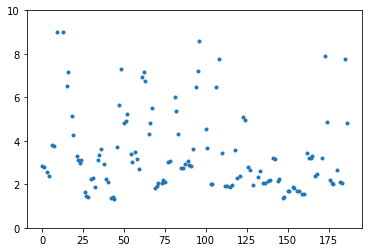

In [12]:
bjd_l = np.array(combined_df["bjd"])


plt.plot((bjd_l[1:]-bjd_l[0:len(bjd_l)-1])*24*60, ".")
plt.ylim(0, 10)

len(np.unique(np.floor(bjd_l)))

In [424]:
len(bjd_l[1:])

173

Text(0, 0.5, 'RV (m/s)')

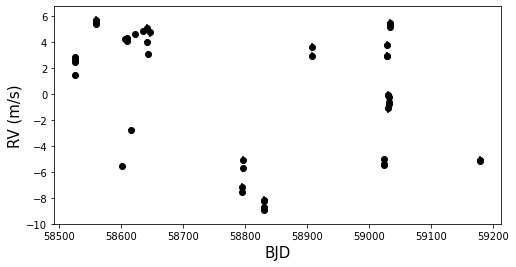

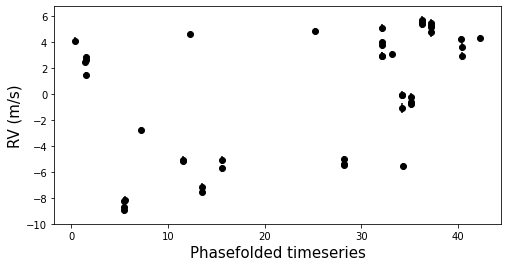

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.errorbar(combined_df["bjd"], combined_df["vrad"]-np.mean(combined_df["vrad"]),
            yerr = combined_df["svrad"], fmt = 'o', color='k')
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)


period = 43
# Phasefolded plot
fig, ax1 = plt.subplots(1,1, figsize=(8, 4))
ax1.errorbar(combined_df["bjd"]%period, combined_df["vrad"]-np.mean(combined_df["vrad"]),
             yerr = combined_df["svrad"], fmt = 'o', color='k')
ax1.set_xlabel("Phasefolded timeseries", size=15)
ax1.set_ylabel("RV (m/s)",size=15)

In [10]:
# master shifting function that allows you to choose whether to shift by the best fit or provided rvs

def master_shifting_EXPRES(bjd, ccfBary, fwhm, wls, rvh, srvh,
                           ref_frame_shift,  # "off" or a specific value in km/s
                           removed_planet_rvs,  # array of rv values for planet signal in km/s OR "NULL"
                           zero_or_median,# "zero" or "median"
                           shift_by_rv):  # "best_fit" or "provided rvs"
    number_of_ccfs = len(ccfBary)

    # HARPS direct data lists
    BJD_list = []
    og_ccf_list = []
    rv_from_HARPS_list = []
    rv_from_HARPS_error_list = []
    v_rad_raw_list = []

    # mpyfit lists
    mu_og_list = []
    mu_jup_list = []
    mu_planet_list = []
    mu_zero_list = []
    sigma_og_list = []
    
    # CCF lists
    compiled_ccf_list = []
    jup_shifted_CCF_data_list = []
    shifted_CCF_list = []
    final_ccf_list = []
    CCF_normalized_list = []

    spline_method = 'cubic'
    for i in range(0, number_of_ccfs):
        day_of_observation = bjd[i]
        BJD_list.append(day_of_observation)

        # extracts the CCF data and rv from fits
        CCF_data = ccfBary[i]
        og_ccf_list.append(CCF_data)
        rv_from_HARPS = rvh[i]
        rv_from_HARPS_list.append(rv_from_HARPS)
        rv_from_HARPS_error_list.append(srvh[i])
        rv_data = wls[i]

        # Finds the local minima using a Gaussian fit
        # Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
        def gauss(x, p):
            return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3]

        # A simple minimization function:
        def least(p, args):
            x, y = args
            return gauss(x, p) - y

        m = np.median(CCF_data)
        
        parinfo = [{'fixed': False, 'step': 1e-4*m},
                   {'fixed': False, 'step': 1e-6},
                   {'fixed': False, 'step': 1e-4},
                   {'fixed': False, 'step': 1e-3*m}]
        
        # no_shift fit
        std = fwhm_sigma(m-CCF_data, rv_data)[1]
        sigma_og_list.append(std)
        index_mean = np.argmin(CCF_data)
        p0 = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
             rv_data[index_mean],
             std,
             m]
        
        pfit_no_shift, results_no_shift = mpyfit.fit(least, p0, (rv_data, CCF_data), parinfo)
        mu_og = pfit_no_shift[1]
        mu_og_list.append(mu_og)
        compiled_ccf_list.append(CCF_data)

        # Add in reference frame shift
        
        if removed_planet_rvs[0] != "NULL":  # Remove known planet signals *a priori*
            jupiter_shift = removed_planet_rvs[i]
            v_rad_raw = rvh[i] + removed_planet_rvs[i]
            v_rad_raw_list.append(v_rad_raw)

            # planet removal shift
            rv_data_jupiter_shift = rv_data + jupiter_shift  # minus sign
            f_jup = interp1d(rv_data_jupiter_shift, CCF_data, kind=spline_method, fill_value='extrapolate')
            jupiter_shifted_CCF_data = f_jup(rv_data)
            jup_shifted_CCF_data_list.append(jupiter_shifted_CCF_data)
            compiled_ccf_list.append(jupiter_shifted_CCF_data)

            # fits the shifted by planets removed data
            p_shifted_jup =[(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
                             rv_data[index_mean]+ jupiter_shift,
                             std,
                             m]
            pfit_jup, results_jup = mpyfit.fit(least, p_shifted_jup, (rv_data, jupiter_shifted_CCF_data), parinfo)
            m_jup = pfit_jup[1]
            mu_jup_list.append(m_jup)

            if zero_or_median == "zero":
                # Shift to zero
                ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]

                shift_to_zero = -(rv_from_HARPS)
                rv_data_shifted = rv_data + shift_to_zero

                f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                shifted_CCF_data = f(rv_data)
                shifted_CCF_list.append(shifted_CCF_data)
                compiled_ccf_list.append(shifted_CCF_data)

                # fits the shifted data
                p_shifted = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
                             rv_data[index_mean]- shift_to_zero,
                             std,
                             m]
                pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                m_zero = pfit[1]
                mu_zero_list.append(m_zero)  # -0.1)
            else:  # shifted to median instead
                ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
                
                if shift_by_rv == "best_fit": #use the originally fitted values to shift by
                    shift_to_median = (np.mean(rvh) - m_jup)
                    rv_data_shifted = rv_data + shift_to_median

                    f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                    shifted_CCF_data = f(rv_data)
                    shifted_CCF_list.append(shifted_CCF_data)
                    compiled_ccf_list.append(shifted_CCF_data)

                    # fits the shifted data
                    p_shifted = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
                                 rv_data[index_mean]-shift_to_median,
                                 std,
                                 m]
                    pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                    m_zero = pfit[1]
                    mu_zero_list.append(m_zero)  # -0.1)
                
                else: #shift by provided rvs
                    shift_to_median = (np.mean(rvh) - rv_from_HARPS)
                    rv_data_shifted = rv_data + shift_to_median

                    f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                    shifted_CCF_data = f(rv_data)
                    shifted_CCF_list.append(shifted_CCF_data)
                    compiled_ccf_list.append(shifted_CCF_data)

                    # fits the shifted data
                    p_shifted = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
                                 rv_data[index_mean]-shift_to_median,
                                 std,
                                 m]
                    pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                    m_zero = pfit[1]
                    mu_zero_list.append(m_zero)  # -0.1)
        else:  # Do not remove any planet signals *a priori*
            ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
            if zero_or_median == "zero":
                # Shift to zero

                shift_to_zero = -(rv_from_HARPS)
                rv_data_shifted = rv_data + shift_to_zero

                f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                shifted_CCF_data = f(rv_data)
                shifted_CCF_list.append(shifted_CCF_data)
                compiled_ccf_list.append(shifted_CCF_data)

                # fits the shifted data
                p_shifted = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
                                 rv_data[index_mean]-shift_to_zero,
                                 std,
                                 m]
                pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                m_zero = pfit[1]
                mu_zero_list.append(m_zero)  # -0.1)
            else:  # shifted to median instead
                if shift_by_rv == "best_fit": #use the originally fitted values to shift by
                    #print(shift_by_rv)
                    shift_to_median = (np.mean(rvh) - mu_og)
                    rv_data_shifted = rv_data + shift_to_median

                    f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                    shifted_CCF_data = f(rv_data)
                    shifted_CCF_list.append(shifted_CCF_data)
                    compiled_ccf_list.append(shifted_CCF_data)

                    # fits the shifted data
                    p_shifted = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
                                 rv_data[index_mean]-shift_to_median,
                                 std,
                                 m]
                    pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                    m_zero = pfit[1]
                    mu_zero_list.append(m_zero)  # -0.1)
                
                else: #shift by provided rvs
                    shift_to_median = (np.mean(rvh) - rv_from_HARPS)
                    rv_data_shifted = rv_data + shift_to_median

                    f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                    shifted_CCF_data = f(rv_data)
                    shifted_CCF_list.append(shifted_CCF_data)
                    compiled_ccf_list.append(shifted_CCF_data)

                    # fits the shifted data
                    p_shifted = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
                                 rv_data[index_mean]-shift_to_median,
                                 std,
                                 m]
                    pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                    m_zero = pfit[1]
                    mu_zero_list.append(m_zero)  # -0.1)
        ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
        final_ccf_list.append(ccf_to_use)

        # normalize the CCFs
        x_left = ccf_to_use[0:150]
        x_right = ccf_to_use[573:723]
        x_norm_range = list(x_left) + list(x_right)
        CCF_normalized = ccf_to_use * (1 / np.mean(x_norm_range))
        CCF_normalized_list.append(CCF_normalized)

    # Create a dataframe
    d = {'BJD': BJD_list,
         'fwhm': fwhm,
         'wls': wls,
         'vrad_star': rvh,
         'svrad_star': srvh,
         'og_ccf_list': og_ccf_list,
         'zero_shifted_CCF_list': shifted_CCF_list,
         'CCF_normalized_list': CCF_normalized_list,
         'mu_og_list': mu_og_list,
         'sigma_og_list': sigma_og_list,
         'mu_zero_list': mu_zero_list,
         'zero_or_median': zero_or_median,
         'shift_by_rv': shift_by_rv,
         }
    df = pd.DataFrame(data=d)

    return df

0.0 1.0
0.0 1.0
0.0 1.0


(773,)

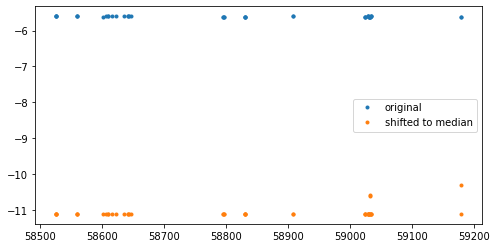

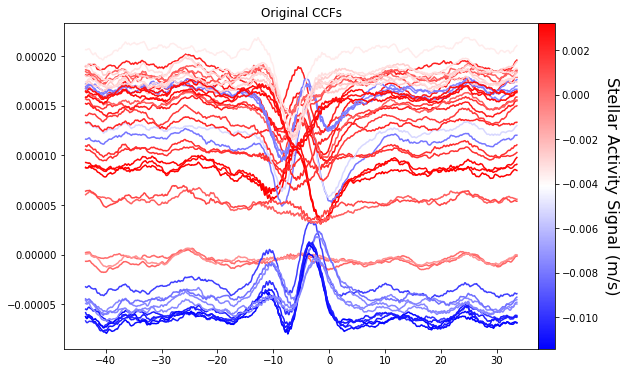

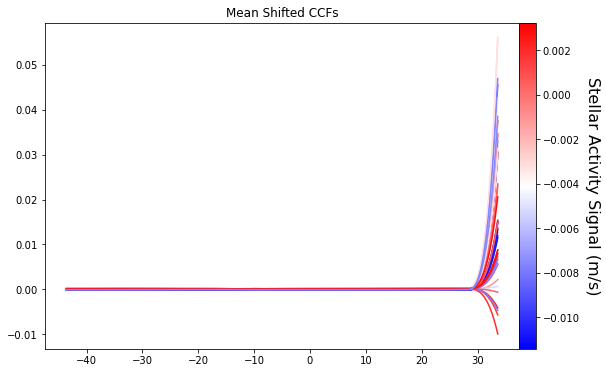

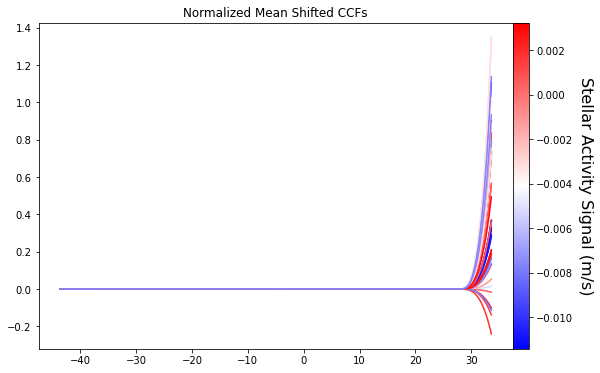

In [11]:
bjd = combined_df["bjd"]
ccf = combined_df["ccf"]
wlsoln =  combined_df["wls"]
vrad = combined_df["vrad"]
svrad = combined_df["svrad"]
fwhm = combined_df["fwhm"]
zero_or_median = "median"
shift_by_rv = "best_fit"


df_master = master_shifting_EXPRES(bjd, ccf, fwhm, wlsoln,
                    vrad/1000,svrad/1000,
                    ref_frame_shift="off", #"off" or a specific value in km/s
                    removed_planet_rvs=['NULL'], #array of rv values for planet signal in km/s
                    zero_or_median = zero_or_median,
                    shift_by_rv = shift_by_rv)

mu_plotting(df_master,["mu_og_list", "mu_zero_list"],
            ["original", "shifted to "+str(zero_or_median)])

residual_plot(df_master["vrad_star"], df_master["wls"][0],df_master["og_ccf_list"], 0, plot_title = "Original CCFs")
#residual_plot(df_master["vrad_star"], df_master["planet_shifted_CCF_data_list"], "median", plot_title = "Injected Planet Shifted CCFs")
residual_plot(df_master["vrad_star"], df_master["wls"][0], df_master["zero_shifted_CCF_list"], 0, plot_title = "Mean Shifted CCFs")
residual_plot(df_master["vrad_star"], df_master["wls"][0], df_master["CCF_normalized_list"], 0, plot_title = "Normalized Mean Shifted CCFs")


df_master
np.shape(df_master["wls"][0])

0.0 1.0


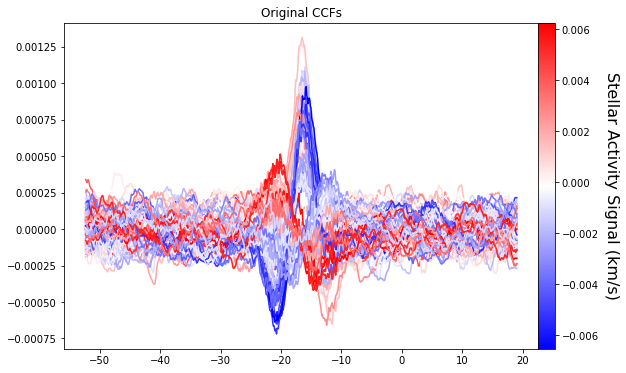

In [81]:
# Residual plot of original ccfs

CCF_og_normalized_list = []

for i in np.arange(0, len(df_master["og_ccf_list"])):
    ccf_to_use = df_master["og_ccf_list"][i]

    # normalize the CCFs
    x_left = ccf_to_use[0:150]
    x_right = ccf_to_use[573:723]
    x_norm_range = list(x_left) + list(x_right)
    CCF_normalized = ccf_to_use * (1 / np.mean(x_norm_range))
    CCF_og_normalized_list.append(list(CCF_normalized))
    

residual_plot(df_master["vrad_star"], df_master["wls"][0],np.array(CCF_og_normalized_list), "median", plot_title = "Original CCFs")

In [37]:
print(np.shape(np.array([df_master["wls"]])))

str(np.shape(np.array([df_master["wls"]]))[2])+"E"

np.shape(np.array([df_master["wls"]]))[2]

(1, 188, 797)


797

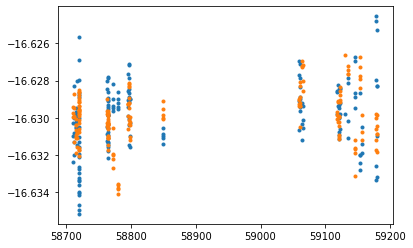

In [162]:
# write it all to one file
bjd = combined_df["bjd"]
ccf = combined_df["ccf"]
wlsoln =  combined_df["wls"]
vrad = combined_df["vrad"]
svrad = combined_df["svrad"]
fwhm = combined_df["fwhm"]
zero_or_median = "median"
shift_by_rv = "prov_rvs" #"best_fit" or "prov_rvs"

df_master = master_shifting_EXPRES(bjd, ccf, fwhm, wlsoln,
                    vrad/1000,svrad/1000,
                    ref_frame_shift="off", #"off" or a specific value in km/s
                    removed_planet_rvs=['NULL'], #array of rv values for planet signal in km/s
                    zero_or_median = zero_or_median,
                    shift_by_rv = shift_by_rv)

#creates columns in CCF.fits files
col1 = fits.Column(name='bjd', format='E', array=df_master["BJD"])
col2 = fits.Column(name='fwhm', format='E', array=df_master["fwhm"])

# ccf params
dim1= np.shape(np.array([df_master["wls"]]))[2]
dim1_str = str(np.shape(np.array([df_master["wls"]]))[2])+"E"
dim2= np.shape(np.array([df_master["wls"]]))[1]

col3 = fits.Column(name='wls', format=dim1_str, dim='(dim2)', 
                   array=np.array([df_master["wls"]]).reshape((dim2, dim1)))
col4 = fits.Column(name='og_ccf', format=dim1_str, dim='(dim2)', 
                   array=np.array([df_master["og_ccf_list"]]).reshape((dim2, dim1)))
col5 = fits.Column(name='shifted_ccf', format=dim1_str, dim='(dim2)', 
                   array=np.array([df_master["zero_shifted_CCF_list"]]).reshape((dim2, dim1)))
col6 = fits.Column(name='norm_shifted_ccf', format=dim1_str, dim='(174)', 
                   array=np.array([df_master["CCF_normalized_list"]]).reshape((dim2, dim1)))

# mu fit params
col7 = fits.Column(name='mu_og_list', format='E', array=df_master["mu_og_list"])
col8 = fits.Column(name='mu_zero_list', format='E', array=df_master["mu_zero_list"])

# rv and textfile params
col9 = fits.Column(name='zero_or_median', format='10A', array=df_master["zero_or_median"])
col10 = fits.Column(name='shift_by_rv', format='10A', array=df_master["shift_by_rv"])
col11 = fits.Column(name='vrad_star', format='E', array=df_master["vrad_star"])
col12 = fits.Column(name='svrad_star', format='E', array=df_master["svrad_star"])


cols1 = fits.ColDefs([col3, col4, col5, col6])

cols2 = fits.ColDefs([col1, col2, col7, col8, col9, col10, col11, col12])

#hdu = fits.PrimaryHDU()
primary_hdu = fits.PrimaryHDU()
t = fits.BinTableHDU.from_columns([col3, col4, col5, col6])
table_hdu2 = fits.BinTableHDU.from_columns([col1, col2, col7, col8, 
                                            col9, col10, col11, col12])

hdul = fits.HDUList([primary_hdu, t, table_hdu2])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/shifted_ccfs'):
    os.makedirs('HD'+star_name+'/shifted_ccfs')

hdul.writeto('HD'+star_name+'/shifted_ccfs/shifted_ccfs_combined_'+shift_by_rv+'test.fits')
hdul.close()


# test plots
plt.plot(df_master["BJD"], df_master["mu_og_list"],".")
plt.plot(df_master["BJD"], df_master["mu_zero_list"],".")

In [160]:
np.std(df_master["vrad_star"], ddof=1)

0.0023484346331328486

0.0023485112

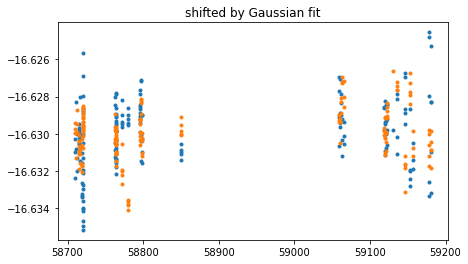

In [163]:
# Check file contents
file_ending = "prov_rvs" #"prov_rvs" #"best_fit" #provided_rvs


hdul_zero = fits.open('HD'+star_name+'/shifted_ccfs/shifted_ccfs_combined_'+file_ending+'test.fits', memmap=False)

# extracts activity signal and rv_data
wls = hdul_zero[1].data['wls']
norm_shifted_ccf = hdul_zero[1].data['norm_shifted_ccf']
bjd = hdul_zero[2].data['bjd']

#plt.plot(wls[0], norm_shifted_ccf[0])
fig, ax = plt.subplots(1,1, figsize=(7, 4))
plt.plot(bjd,hdul_zero[2].data['mu_og_list'], ".")
plt.plot(bjd,hdul_zero[2].data['mu_zero_list'], ".")
plt.title("shifted by Gaussian fit")

np.std(hdul_zero[2].data["vrad_star"], ddof=1)


0.0 1.0


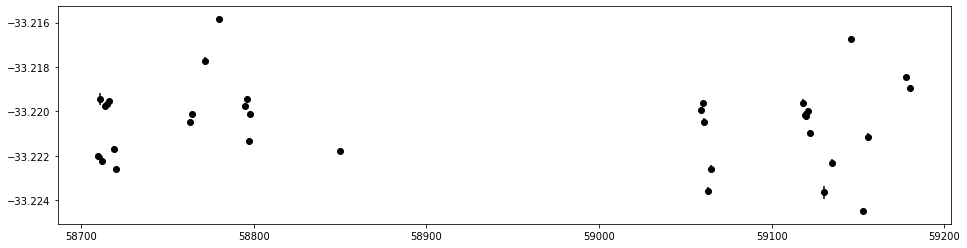

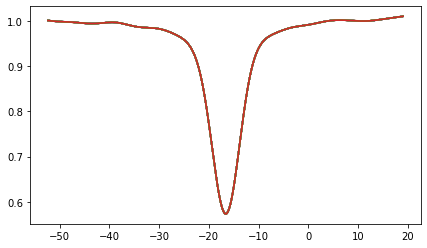

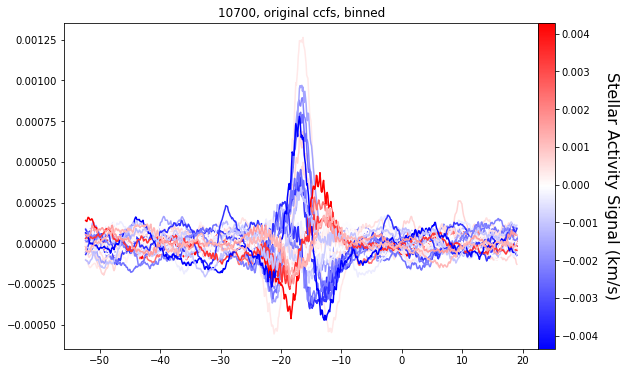

In [164]:
# binning the data next!

norm_shifted_ccf = hdul_zero[1].data['norm_shifted_ccf'] #np.array(CCF_og_normalized_list) 
wls = hdul_zero[1].data['wls']
bjd_l = hdul_zero[2].data['bjd']
fwhm = hdul_zero[2].data['fwhm']
mu_og_list = hdul_zero[2].data['mu_og_list']
mu_zero_list = hdul_zero[2].data['mu_zero_list']
vrad_star = hdul_zero[2].data['vrad_star']
svrad_star = hdul_zero[2].data['svrad_star']
zero_or_median = hdul_zero[2].data['zero_or_median']
shift_by_rv = hdul_zero[2].data['shift_by_rv']

len(np.unique(np.floor(bjd_l)))

unique_bjds = np.unique(np.floor(bjd_l))

binned_bjds = []
binned_RVs = []
binned_uncertainties = []
binned_ccfs = []
binned_fwhm = []
binned_mu_og = []
binned_mu_zero = []
for i in range(0, len(unique_bjds)):
    index= np.where(np.abs(np.floor(bjd_l)-unique_bjds[i]) == 0)
    #print(bjd_l[index])
    #print(svrad_star[index])
    weighted_avg_bjd = np.sum(bjd_l[index]/svrad_star[index]**2)/np.sum(1/svrad_star[index]**2)
    weighted_avg_ccf = np.average(norm_shifted_ccf[index], weights=svrad_star[index], axis=0)
    weighted_avg_wls = np.average(wls[index], weights=svrad_star[index], axis=0)
    weighted_avg_fwhm = np.sum(fwhm[index]/svrad_star[index]**2)/np.sum(1/svrad_star[index]**2)
    weighted_avg_mu_og = np.sum(mu_og_list[index]/svrad_star[index]**2)/np.sum(1/svrad_star[index]**2)
    weighted_avg_mu_zero = np.sum(mu_zero_list[index]/svrad_star[index]**2)/np.sum(1/svrad_star[index]**2)
    
    weighted_avg_rv = np.sum(vrad_star[index]/svrad_star[index]**2)/np.sum(1/svrad_star[index]**2)
    weighted_avg_srv = np.sqrt(1.0/np.sum(1.0/svrad_star[index]**2))
    
    binned_bjds.append(weighted_avg_bjd)
    binned_ccfs.append(weighted_avg_ccf)
    binned_fwhm.append(weighted_avg_fwhm)
    binned_mu_og.append(weighted_avg_mu_og)
    binned_mu_zero.append(weighted_avg_mu_zero)
    binned_RVs.append(weighted_avg_rv)
    binned_uncertainties.append(weighted_avg_srv)
    
fig, ax = plt.subplots(1,1, figsize=(16, 4))
plt.errorbar(unique_bjds, binned_RVs, yerr=binned_uncertainties,  fmt = 'o', color='k')

fig, ax = plt.subplots(1,1, figsize=(7, 4))
for i in np.arange(0, len(binned_ccfs)):
    plt.plot(weighted_avg_wls, binned_ccfs[i])

residual_plot(binned_RVs, weighted_avg_wls, binned_ccfs, "median", plot_title = star_name+", original ccfs, binned")

# Writing the binned data to a file
#creates columns in CCF.fits files
col1 = fits.Column(name='bjd', format='E', array=binned_bjds)
col2 = fits.Column(name='fwhm', format='E', array=binned_fwhm)

# ccf params
dim2 = len(unique_bjds)
col3 = fits.Column(name='wls', format=dim1_str, dim='(1)', 
                   array=[weighted_avg_wls])
col4 = fits.Column(name='binned_ccfs', format=dim1_str, dim='(dim2)', 
                   array=np.array(binned_ccfs).reshape((dim2, dim1)))

# rv and textfile params
col5 = fits.Column(name='zero_or_median', format='10A', array=zero_or_median[0:len(binned_RVs)])
col6 = fits.Column(name='shift_by_rv', format='10A', array=shift_by_rv[0:len(binned_RVs)])
col7 = fits.Column(name='vrad_star', format='E', array=binned_RVs)
col8 = fits.Column(name='svrad_star', format='E', array=binned_uncertainties)
col9 = fits.Column(name='mu_og_list', format='E', array=binned_mu_og)
col10 = fits.Column(name='mu_zero_list', format='E', array=binned_mu_zero)


cols1 = fits.ColDefs([col3, col4])

cols2 = fits.ColDefs([col1, col2, col5, col6,
                      col7, col8])

#hdu = fits.PrimaryHDU()
primary_hdu = fits.PrimaryHDU()
t = fits.BinTableHDU.from_columns([col3, col4])
table_hdu2 = fits.BinTableHDU.from_columns([col1, col2, col5, col6,
                                            col7, col8, col9, col10])

hdul = fits.HDUList([primary_hdu, t, table_hdu2])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/binned_ccfs'):
    os.makedirs('HD'+star_name+'/binned_ccfs')

#hdul.writeto('HD'+star_name+'/binned_ccfs/binned_ccfs_'+file_ending+'.fits')
hdul.close()

In [165]:
print(np.std(vrad_star, ddof=1))
np.std(binned_RVs, ddof=1)

0.0023485112


0.001861004

In [87]:
len(zero_or_median)

174

In [77]:
len(weighted_avg_wls)

715

In [56]:
svrad_star[index]

array([0.000292, 0.00029 , 0.000288, 0.000291, 0.000288], dtype=float32)

In [67]:
np.sum(([[1,1],[2,2]])/np.array([1,0.5]), axis=0) 

([[1,1],[2,2]])/np.array([[0.5],[1]])

1*1/(1.5)+2*0.5/1.5

3*1/(1.5)+2*0.5/1.5

2.6666666666666665

In [66]:
np.average([[1,3],[2,2]], weights=[1,0.5], axis=0)

array([1.33333333, 2.66666667])

## Old code below (May 31, 2021)

In [445]:
# OLD 

# testing adding wiggle params


def master_shifting(bjd, ccfBary, wls, rvh, srvh,
                           ref_frame_shift,  # "off" or a specific value in km/s
                           removed_planet_rvs,  # array of rv values for planet signal in km/s OR "NULL"
                           zero_or_median):  # "zero" or "median"
    number_of_ccfs = len(ccfBary)

    # HARPS direct data lists
    BJD_list = []
    og_ccf_list = []
    rv_from_HARPS_list = []
    rv_from_HARPS_error_list = []
    v_rad_raw_list = []

    # mpyfit lists
    mu_og_list = []
    mu_jup_list = []
    mu_planet_list = []
    mu_zero_list = []
    sigma_og_list = []
    
    # CCF lists
    compiled_ccf_list = []
    jup_shifted_CCF_data_list = []
    shifted_CCF_list = []
    final_ccf_list = []
    CCF_normalized_list = []

    spline_method = 'cubic'
    for i in range(0, number_of_ccfs):
        day_of_observation = bjd[i]
        BJD_list.append(day_of_observation)

        # extracts the CCF data and rv from fits
        CCF_data = ccfBary[i]
        og_ccf_list.append(CCF_data)
        rv_from_HARPS = rvh[i]
        rv_from_HARPS_list.append(rv_from_HARPS)
        rv_from_HARPS_error_list.append(srvh[i])

        # Finds the local minima using a Gaussian fit
        # Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
        def gauss(x, p, z):
            return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2))+ p[3] + p[4]*(x - p[1])**2 +z[10] + z[9]*x + z[8]*x**2 + z[7]*x**3 + z[6]*x**4 +  z[5]*x**5 +  z[4]*x**6 +  z[3]*x**7 +  z[2]*x**8 +  z[1]*x**9 +  z[0]*x**10 
        

        # A simple minimization function:
        def least(p, args):
            x, y, z = args
            return gauss(x, p, z) - y

        parinfo = [{'fixed': False, 'step': 1e-4*np.max(CCF_data)},
                           {'fixed': False, 'step': 1e-6},
                           {'fixed': False, 'step': 1e-4},
                           {'fixed': False, 'step': 1e-4*np.max(CCF_data)}, 
                           {'fixed': False, 'step': 1e-4*np.max(CCF_data)}]
        
        # no_shift fit
        rv_data = wls[i]
        amp_og_guess = np.max(CCF_data)-np.min(CCF_data)
        offset_og_guess = np.max(CCF_data)
        index_og = np.argmin(CCF_data)
        sigma_og = fwhm_sigma(CCF_data, rv_data)[1]
        sigma_og_list.append(sigma_og)
        
        p_no_shifted = [amp_og_guess, rv_data[index_og], sigma_og, offset_og_guess]
        pfit_no_shift, results_no_shift = mpyfit.fit(least, p_no_shifted, (rv_data, CCF_data), parinfo)
        mu_og = pfit_no_shift[1]
        mu_og_list.append(mu_og)
        compiled_ccf_list.append(CCF_data)

        # Add in reference frame shift
        
        #fixed wiggle params
        z = np.array([-6.48333753e-18, -1.11367630e-15, -6.54564148e-14, -1.08401170e-12,
        3.33604219e-11,  1.29740367e-09,  2.25677200e-09, -3.76694510e-07,
        -2.19586666e-06,  6.65824519e-05,  2.84049231e-02])
        
        if removed_planet_rvs[0] != "NULL":  # Remove known planet signals *a priori*
            jupiter_shift = removed_planet_rvs[i]
            v_rad_raw = rvh[i] + removed_planet_rvs[i]
            v_rad_raw_list.append(v_rad_raw)

            # planet removal shift
            rv_data_jupiter_shift = rv_data + jupiter_shift  # minus sign
            f_jup = interp1d(rv_data_jupiter_shift, CCF_data, kind=spline_method, fill_value='extrapolate')
            jupiter_shifted_CCF_data = f_jup(rv_data)
            jup_shifted_CCF_data_list.append(jupiter_shifted_CCF_data)
            compiled_ccf_list.append(jupiter_shifted_CCF_data)

            # fits the shifted by planets removed data
            p_shifted_jup = [amp_og_guess, rv_data[index_mean], 
                     sigma_og, offset_og_guess, 6e-7]
            pfit_jup, results_jup = mpyfit.fit(least, p_shifted_jup, (rv_data, jupiter_shifted_CCF_data), parinfo)
            m = pfit_jup[1]
            mu_jup_list.append(m)

            if zero_or_median == "zero":
                # Shift to zero
                ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]

                shift_to_zero = -(rv_from_HARPS)
                rv_data_shifted = rv_data + shift_to_zero

                f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                shifted_CCF_data = f(rv_data)
                shifted_CCF_list.append(shifted_CCF_data)
                compiled_ccf_list.append(shifted_CCF_data)

                # fits the shifted data
                p_shifted = [amp_og_guess, rv_data[index_mean], 
                     sigma_og, offset_og_guess, 6e-7]
                pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                m_zero = pfit[1]
                mu_zero_list.append(m_zero)  # -0.1)
            else:  # shifted to median instead
                ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
                shift_to_median = (np.mean(rvh) - rv_from_HARPS)
                rv_data_shifted = rv_data + shift_to_median

                f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                shifted_CCF_data = f(rv_data)
                shifted_CCF_list.append(shifted_CCF_data)
                compiled_ccf_list.append(shifted_CCF_data)

                # fits the shifted data
                p_shifted = [amp_og_guess, rv_data[index_mean], 
                     sigma_og, offset_og_guess, 6e-7]
                pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                m_zero = pfit[1]
                mu_zero_list.append(m_zero)  # -0.1)
        else:  # Do not remove any planet signals *a priori*
            if zero_or_median == "zero":
                # Shift to zero
                ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]

                shift_to_zero = -(rv_from_HARPS)
                rv_data_shifted = rv_data + shift_to_zero

                f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                shifted_CCF_data = f(rv_data)
                shifted_CCF_list.append(shifted_CCF_data)
                compiled_ccf_list.append(shifted_CCF_data)

                # fits the shifted data
                p_shifted = [amp_og_guess, rv_data[index_mean], 
                     sigma_og, offset_og_guess, 6e-7]
                pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                m_zero = pfit[1]
                mu_zero_list.append(m_zero)  # -0.1)
            else:  # shifted to median instead
                ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
                shift_to_median = (np.mean(rvh)+0. - rv_from_HARPS)
                rv_data_shifted = rv_data + shift_to_median

                f = interp1d(rv_data_shifted, ccf_to_use, kind=spline_method, fill_value='extrapolate')
                shifted_CCF_data = f(rv_data)
                shifted_CCF_list.append(shifted_CCF_data)
                compiled_ccf_list.append(shifted_CCF_data)
                
                # calculate index of max for initial guess for mu 
                index_mean = np.argmin(shifted_CCF_data)

                # fits the shifted data
                p_shifted = [amp_og_guess, rv_data[index_mean], 
                     sigma_og, offset_og_guess, 6e-7]
                pfit, results = mpyfit.fit(least, p_shifted, (rv_data, shifted_CCF_data), parinfo)
                m_zero = pfit[1]
                mu_zero_list.append(m_zero)  # -0.1)
        ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
        final_ccf_list.append(ccf_to_use)

        # normalize the CCFs
        x_left = ccf_to_use[0:150]
        x_right = ccf_to_use[573:723]
        x_norm_range = list(x_left) + list(x_right)
        CCF_normalized = ccf_to_use * (1 / np.mean(x_norm_range))
        CCF_normalized_list.append(CCF_normalized)

    # Create a dataframe
    d = {'BJD': BJD_list,
         'wls': wls,
         'vrad_star': rvh,
         'svrad_star': srvh,
         'og_ccf_list': og_ccf_list,
         'zero_shifted_CCF_list': shifted_CCF_list,
         'CCF_normalized_list': CCF_normalized_list,
         'mu_og_list': mu_og_list,
         'mu_zero_list': mu_zero_list
         }
    df = pd.DataFrame(data=d)

    return df

In [446]:
bjd = combined_df["bjd"]
ccf = combined_df["ccf"]
wlsoln =  combined_df["wls"]
vrad = combined_df["vrad"]
svrad = combined_df["svrad"]
zero_or_median = "median"

# generate list of reference frame shifts
ref_diff_list = []
for i in range(0, len(bjd)):
    ref_diff =combined_df["wls"][0][0]-combined_df["wls"][i][0]
    ref_diff_list.append(ref_diff)


df_master = master_shifting(bjd, ccf, wlsoln,
                    vrad/1000,svrad/1000,
                    ref_frame_shift="off", #"off" or a specific value in km/s
                    removed_planet_rvs=['NULL'], #array of rv values for planet signal in km/s
                    zero_or_median = zero_or_median)

df_master

mu_plotting(df_master,["mu_og_list", "mu_zero_list"],
            ["original", "shifted to "+str(zero_or_median)])

residual_plot(df_master["vrad_star"], df_master["og_ccf_list"], 0, plot_title = "Original CCFs")
#residual_plot(df_master["vrad_star"], df_master["planet_shifted_CCF_data_list"], "median", plot_title = "Injected Planet Shifted CCFs")
residual_plot(df_master["vrad_star"], df_master["zero_shifted_CCF_list"], 0, plot_title = "Mean Shifted CCFs")
residual_plot(df_master["vrad_star"], df_master["CCF_normalized_list"], 0, plot_title = "Normalized Mean Shifted CCFs")


TypeError: the parameters and the parameter info list do not have equal lengths

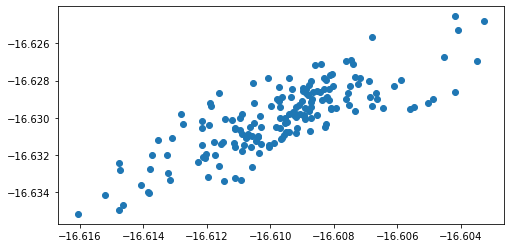

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plt.scatter(df_master["vrad_star"], df_master["mu_og_list"])

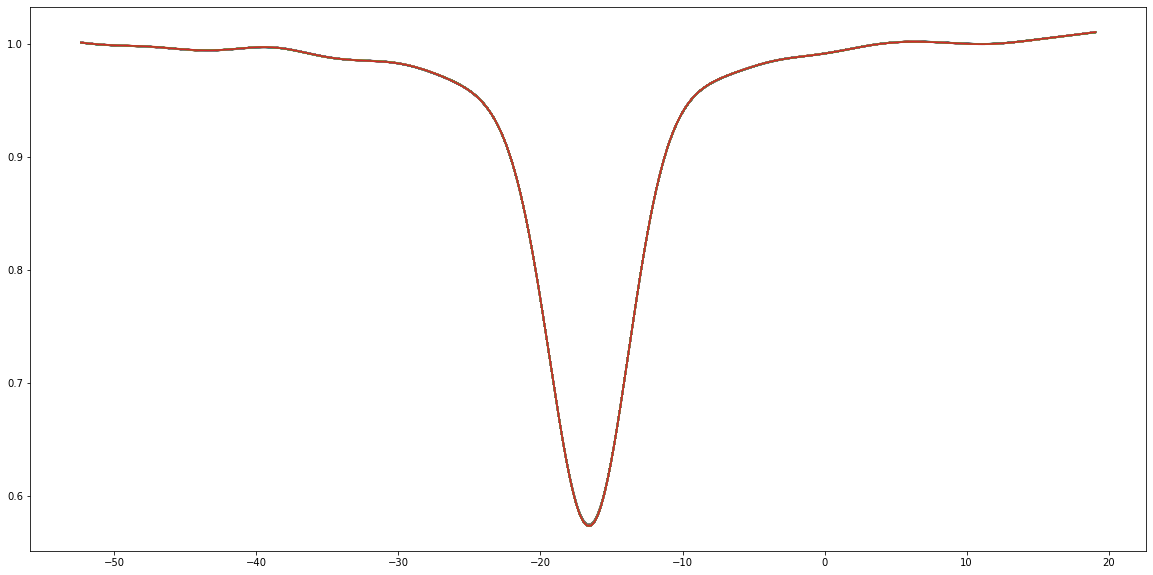

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for i in np.arange(0, len(df_master["wls"])):
    plt.plot(df_master["wls"][i], df_master["CCF_normalized_list"][i])

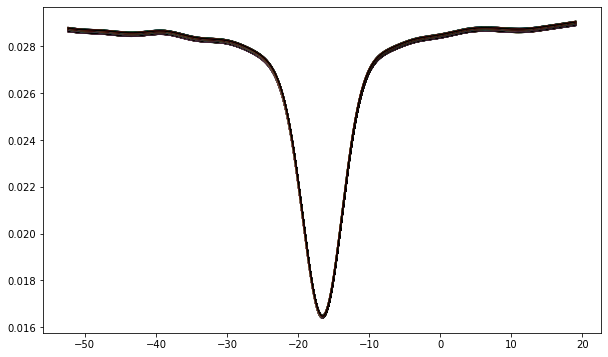

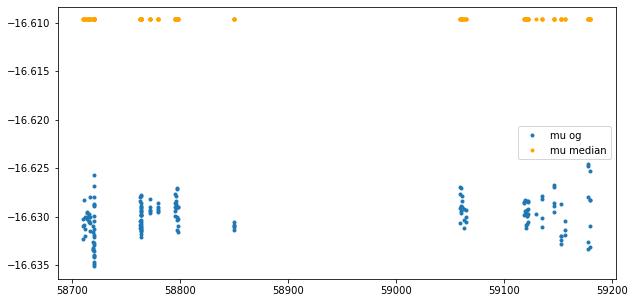

In [101]:
    # clean, startover shifter (05/31)
    
    bjd = combined_df["bjd"]
    ccfBary = combined_df["ccf"]
    wls =  combined_df["wls"]
    vrad = combined_df["vrad"]
    svrad = combined_df["svrad"]
    zero_or_median = "median"
    rvh = vrad/1000
    srvh = svrad/1000
    ref_frame_shift="off" #"off" or a specific value in km/s
    removed_planet_rvs=['NULL']
    
    number_of_ccfs = len(ccfBary)
    
    # HARPS direct data lists
    BJD_list = []
    og_ccf_list = []
    rv_from_HARPS_list = []
    rv_from_HARPS_error_list = []
    v_rad_raw_list = []

    # mpyfit lists
    mu_og_list = []
    mu_jup_list = []
    mu_planet_list = []
    mu_zero_list = []
    sigma_og_list = []
    pfit_list = []
    
    # CCF lists
    compiled_ccf_list = []
    jup_shifted_CCF_data_list = []
    shifted_CCF_list = []
    final_ccf_list = []
    CCF_normalized_list = []
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))  
    spline_method = 'quadratic'
    for i in range(0,number_of_ccfs):
        day_of_observation = bjd[i]
        BJD_list.append(day_of_observation)

        # extracts the CCF data and rv from fits
        CCF_data = ccfBary[i]
        og_ccf_list.append(CCF_data)
        rv_from_HARPS = rvh[i]
        rv_from_HARPS_list.append(rv_from_HARPS)
        rv_from_HARPS_error_list.append(srvh[i])
        rv_data = wls[i]
        
        # Finds the local minima using a Gaussian fit
        # Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
        def gauss(x, p):
            return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3]
        
        # A simple minimization function:
        def least(p, args):
            x, y = args
            return gauss(x, p) - y
        
        m = np.median(CCF_data)
        
        parinfo = [{'fixed': False, 'step': 1e-4*m},
                   {'fixed': False, 'step': 1e-6},
                   {'fixed': False, 'step': 1e-4},
                   {'fixed': False, 'step': 1e-3*m}]
        
        # no_shift fit
        std = fwhm_sigma(m-CCF_data, rv_data)[1]
        sigma_og_list.append(std)
        index_mean = np.argmin(CCF_data)
        p0 = [(np.min(CCF_data)-np.max(CCF_data)/np.max(CCF_data))*m,
             rv_data[index_mean],
             std,
             m]
        
        pfit_no_shift, results_no_shift = mpyfit.fit(least, p0, (rv_data, CCF_data), parinfo)
        mu_og = pfit_no_shift[1]
        mu_og_list.append(mu_og)
        compiled_ccf_list.append(CCF_data)
        
        # plot original ccfs
        plt.plot(rv_data, CCF_data, label="original ccfs")
        
        #shift to median
        ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
        shift_to_median = (np.mean(rvh)- mu_og) #(np.mean(rvh) - rv_from_HARPS)
        rv_data_shifted = rv_data + shift_to_median

        f = interp1d(rv_data_shifted, CCF_data, kind=spline_method, fill_value='extrapolate')
        shifted_CCF_data = f(rv_data)
        shifted_CCF_list.append(shifted_CCF_data)
        compiled_ccf_list.append(shifted_CCF_data)
        
        #fit shifted ccfs
        p0_shifted = [amp_og_guess, rv_data[index_mean], 
                     std, m]
        pfit, results = mpyfit.fit(least, p0_shifted, (rv_data, shifted_CCF_data), parinfo)
        pfit_list.append(pfit)
        m_zero = pfit[1]
        mu_zero_list.append(m_zero)
        
        # plot shifted ccfs
        plt.plot(rv_data, shifted_CCF_data, color='k', label="shifted")
    
    ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
    final_ccf_list.append(ccf_to_use)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.plot(BJD_list, mu_og_list, ".", label="mu og")
    plt.plot(BJD_list, mu_zero_list, ".", color= "orange",label="mu median")
    plt.legend()
        
    
    


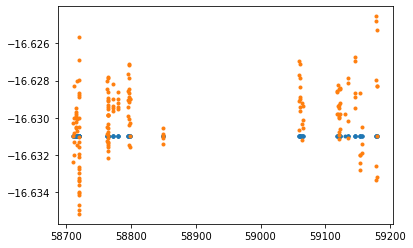

In [97]:
# read in Andrew's files and fit them. (essentially test whether my shifting or fitting is the problem)

hdul_zero = fits.open('HD10700/ccfs_for_andrew/HD10700_ccfs_shifted.fits', memmap=False)

# extracts activity signal and rv_data
ccfs_shifted = hdul_zero[1].data['NEWCCF']
wls  = hdul_zero[1].data["WLS"]
bjd = hdul_zero[1].data["BJD"]
mu_andrew_list = []
        
for i in np.arange(0, len(bjd)):
        # Finds the local minima using a Gaussian fit
        # Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
        def gauss(x, p):
            return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2)) + p[3]
        
        # A simple minimization function:
        def least(p, args):
            x, y = args
            return gauss(x, p) - y
        
        thisccf = ccfs_shifted[i]
        thiswls = wls[i]
        m = np.median(thisccf)
        std = fwhm_sigma(m-thisccf, thiswls)[1]
        index_mean = np.argmin(ccfs_shifted[i])
        p0 = [(np.min(thisccf)-np.max(thisccf)/np.max(thisccf))*m,
             rv_data[index_mean],
             std,
             m]
        
        parinfo = [{'fixed': False, 'step': 1e-4*m},
                   {'fixed': False, 'step': 1e-6},
                   {'fixed': False, 'step': 1e-4},
                   {'fixed': False, 'step': 1e-3*m}]
        
        pfit_shifted, results_shifted = mpyfit.fit(least, p0, (thiswls, thisccf), parinfo)
        mu_andrew = pfit_shifted[1]
        mu_andrew_list.append(mu_og)

plt.plot(bjd, mu_andrew_list, ".")
plt.plot(bjd, mu_og_list, ".")

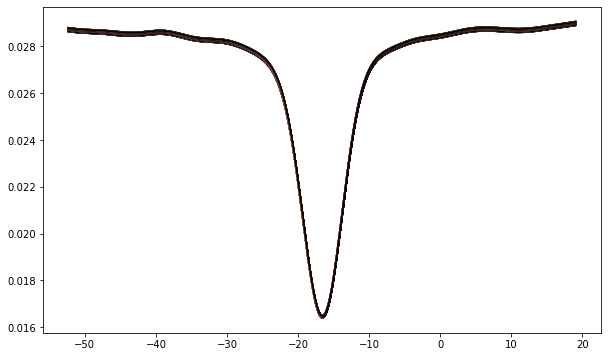

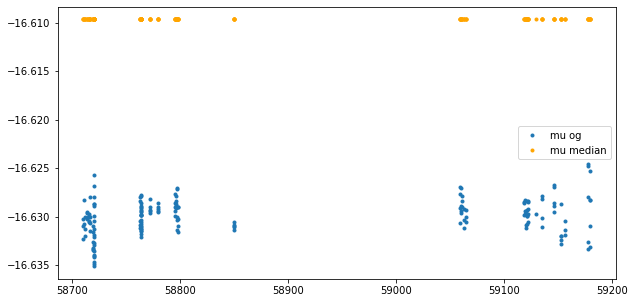

In [99]:
    # testing median shifting
    
    bjd = combined_df["bjd"]
    ccfBary = combined_df["ccf"]
    wls =  combined_df["wls"]
    vrad = combined_df["vrad"]
    svrad = combined_df["svrad"]
    zero_or_median = "median"
    rvh = vrad/1000
    srvh = svrad/1000
    ref_frame_shift="off" #"off" or a specific value in km/s
    removed_planet_rvs=['NULL']
    
    number_of_ccfs = len(ccfBary)

    # HARPS direct data lists
    BJD_list = []
    og_ccf_list = []
    rv_from_HARPS_list = []
    rv_from_HARPS_error_list = []
    v_rad_raw_list = []

    # mpyfit lists
    mu_og_list = []
    mu_jup_list = []
    mu_planet_list = []
    mu_zero_list = []
    sigma_og_list = []
    pfit_list = []
    
    # CCF lists
    compiled_ccf_list = []
    jup_shifted_CCF_data_list = []
    shifted_CCF_list = []
    final_ccf_list = []
    CCF_normalized_list = []
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))  
    spline_method = 'quadratic'
    for i in range(0, number_of_ccfs):
        day_of_observation = bjd[i]
        BJD_list.append(day_of_observation)

        # extracts the CCF data and rv from fits
        CCF_data = ccfBary[i]
        og_ccf_list.append(CCF_data)
        rv_from_HARPS = rvh[i]
        rv_from_HARPS_list.append(rv_from_HARPS)
        rv_from_HARPS_error_list.append(srvh[i])
        rv_data = wls[i]
        
        # calculate index of max for initial guess for mu 
        index_mean = np.argmin(CCF_data)

        # Finds the local minima using a Gaussian fit
        # Define the actual function where     A = p[0], mu = p[1], sigma = p[2], c = p[3]
        def gauss(x, p):
            return -p[0] * np.exp(-(x - p[1]) ** 2 / (2. * p[2] ** 2))+ p[3] #+ p[4]*(x - p[1])**2 +z[10] + z[9]*x + z[8]*x**2 + z[7]*x**3 + z[6]*x**4 +  z[5]*x**5 +  z[4]*x**6 +  z[3]*x**7 +  z[2]*x**8 +  z[1]*x**9 +  z[0]*x**10 
        

        # A simple minimization function:
        def least(p, args):
            x, y = args
            return gauss(x, p) - y
        
        
        m = np.median(CCF_data)
        std = fwhm_sigma(m-CCF_data, rv_data)[1]
        parinfo = [{'fixed': False, 'step': 0.0001*m},
                           {'fixed': False, 'step': 1e-6},
                           {'fixed': False, 'step': 1e-4},
                           {'fixed': False, 'step': 1e-4*m}]#, 
        #                   {'fixed': False, 'step': 1e-4}]#, 
        #                   {'fixed': False, 'step': 1e-5}]#, 
        #                   #{'fixed': False, 'step': 0.1}, 
        #                   #{'fixed': False, 'step': 1e-5}, 
        #                   #{'fixed': False, 'step': 1e-5}, 
        #                   #{'fixed': False, 'step': 0.1}, 
        #                   #{'fixed': False, 'step': 1e-5}]
        
        # fits the shifted data
        #fixed wiggle params
        z = np.array([-6.48333753e-18, -1.11367630e-15, -6.54564148e-14, -1.08401170e-12,
        3.33604219e-11,  1.29740367e-09,  2.25677200e-09, -3.76694510e-07,
        -2.19586666e-06,  6.65824519e-05,  2.84049231e-02])
        
        # no_shift fit
        amp_og_guess = (np.max(CCF_data)-np.min(CCF_data))/np.max(CCF_data)*m
        offset_og_guess = np.max(CCF_data)
        index_og = np.argmin(CCF_data)
        sigma_og = fwhm_sigma(CCF_data, rv_data)[1]
        sigma_og_list.append(sigma_og)
        
        #p_no_shifted = [amp_og_guess, rv_data[index_og]-0.086, 
        #             sigma_og, offset_og_guess, 6e-7]
        p0 = [amp_og_guess, rv_data[index_og], 
                     std, m]#, 6e-7]
        pfit_no_shift, results_no_shift = mpyfit.fit(least, p0, (rv_data, CCF_data), parinfo)
        mu_og = pfit_no_shift[1]
        mu_og_list.append(mu_og)
        compiled_ccf_list.append(CCF_data)
        

        plt.plot(rv_data, CCF_data, label="original ccfs")
        
        #shift to median
        ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
        shift_to_median = (np.mean(rvh)- mu_og) #(np.mean(rvh) - rv_from_HARPS)
        rv_data_shifted = rv_data + shift_to_median

        f = interp1d(rv_data_shifted, CCF_data, kind=spline_method, fill_value='extrapolate')
        shifted_CCF_data = f(rv_data)
        shifted_CCF_list.append(shifted_CCF_data)
        compiled_ccf_list.append(shifted_CCF_data)
              
        plt.plot(rv_data, shifted_CCF_data, color='k', label="shifted")
        #plt.xlim(-20,-15)
        #plt.ylim(0.015,0.023)
            

        
        p_shifted = [amp_og_guess, np.mean(rvh)-0.016, 
                     sigma_og, offset_og_guess]#, 6e-7]#, 0]#, 
        p0_shifted = [amp_og_guess, rv_data[index_mean], 
                     std, m]#, 6e-7]
        #             0, 1.9, -10,  
        #             -1e-4, 1.7, -8.5]
        #fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        #plt.plot(rv_data, shifted_CCF_data)
        #plt.plot(rv_data, gauss(rv_data,p_shifted), label="initial")
        
        #print(p_shifted)
        pfit, results = mpyfit.fit(least, p0_shifted, (rv_data, shifted_CCF_data), parinfo)
        pfit_list.append(pfit)
        m_zero = pfit[1]
        mu_zero_list.append(m_zero)  # -0.1)
        #print(pfit)
        #print("------------")
        
        #fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        #plt.plot(rv_data, shifted_CCF_data)
        #plt.plot(rv_data, gauss(rv_data,pfit, z), label="fitted")
        
    ccf_to_use = compiled_ccf_list[len(compiled_ccf_list) - 1]
    final_ccf_list.append(ccf_to_use)
    
    #plt.legend()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.plot(BJD_list, mu_og_list, ".", label="mu og")
    plt.plot(BJD_list, mu_zero_list, ".", color= "orange",label="mu median")
    #plt.ylim(-0.06,-0.001)
    plt.legend()

In [65]:
np.median(mu_zero_list)

-16.580265362306363

In [539]:
np.std(mu_zero_list)*1000


0.7912652641647993

In [510]:
rv_data[index_mean]

-16.540000000000003

In [511]:
mu_og_list-rv_data[index_og]

array([-0.08658105, -0.08735697, -0.08868914, -0.08464961, -0.08711823,
       -0.08761128, -0.08825427, -0.08644563, -0.08659621, -0.08606014,
       -0.08591598, -0.0863741 , -0.08637138, -0.08687021, -0.08692052,
       -0.08632069, -0.08435182, -0.08650037, -0.0869842 , -0.08779476,
       -0.08970152, -0.08789444, -0.08963939, -0.0888976 , -0.08739784,
       -0.08973357, -0.08527607, -0.0867604 , -0.08906308, -0.08759635,
       -0.08635254, -0.09000665, -0.08848438, -0.08507131, -0.09124963,
       -0.09035754, -0.08495281, -0.09033317, -0.09101071, -0.08420267,
       -0.08925139, -0.09055448, -0.08319842, -0.08829514, -0.09154081,
       -0.08199798, -0.08676286, -0.08757019, -0.0848241 , -0.08727432,
       -0.08448451, -0.08616505, -0.08659116, -0.08585613, -0.08547936,
       -0.08730613, -0.08618226, -0.08780126, -0.08531717, -0.08709774,
       -0.08498525, -0.08542356, -0.08727953, -0.08558212, -0.0878616 ,
       -0.08623372, -0.08691288, -0.08762866, -0.08619057, -0.08

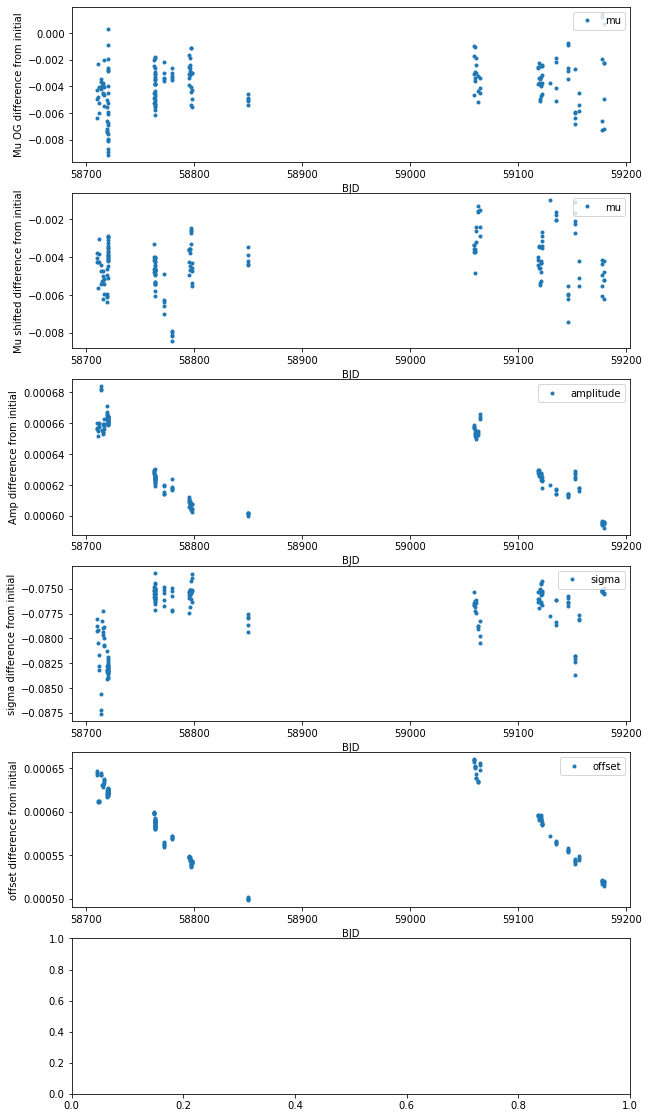

In [29]:
diff_list = np.array(p_shifted)-pfit_list
diff_mu_og = mu_og_list-(rv_data[index_og]-0.086)
diff_mu_shifted = mu_zero_list-(np.mean(rvh)-0.016)
amp_list = []
sigma_list = []
offset_list = []
quadratic_list = []

for i in np.arange(0, len(pfit_list)):
    amp_list.append(diff_list[i][0])
    sigma_list.append(diff_list[i][2])
    offset_list.append(diff_list[i][3])
    #quadratic_list.append(diff_list[i][4])
    
fig, ax = plt.subplots(6, 1, figsize=(10, 20))
ax[0].plot(BJD_list, diff_mu_og, ".", label = "mu")
ax[0].set_ylabel("Mu OG difference from initial")
#ax[0].set_ylim(-0.0061, 0.0043)
ax[1].plot(BJD_list, diff_mu_shifted, ".", label = "mu")
ax[1].set_ylabel("Mu shifted difference from initial")
#ax[1].set_ylim(-0.0061, 0.0043)


ax[2].plot(BJD_list, amp_list, ".", label = "amplitude")
ax[2].set_ylabel("Amp difference from initial")
ax[3].plot(BJD_list, sigma_list, ".", label = "sigma")
ax[3].set_ylabel("sigma difference from initial")
ax[4].plot(BJD_list, offset_list, ".", label = "offset")
ax[4].set_ylabel("offset difference from initial")
#ax[5].plot(BJD_list, quadratic_list, ".", label = "quadratic")
#ax[5].set_ylabel("quadrtic difference from initial")


for i in np.arange(0, 5):
    ax[i].legend(loc="upper right")
    ax[i].set_xlabel("BJD")

In [462]:
diff_list[0]

array([1.39691326e-03, 7.56515394e-02, 1.85355633e-01, 2.90944606e-02,
       5.18644793e-07])

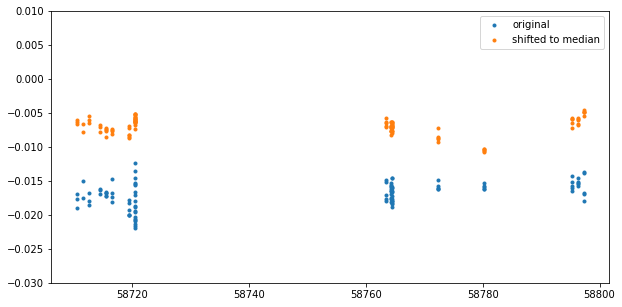

In [454]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(BJD_list, mu_og_list-np.mean(rvh), ".", label="original")
plt.plot(BJD_list, mu_zero_list-np.mean(rvh), ".", label="shifted to median")
plt.ylim(-0.03,0.01)
plt.legend()

In [356]:
len(rv_data)

715

array([-6.48333753e-18, -1.11367630e-15, -6.54564148e-14, -1.08401170e-12,
        3.33604219e-11,  1.29740367e-09,  2.25677200e-09, -3.76694510e-07,
       -2.19586666e-06,  6.65824519e-05,  2.84049231e-02])

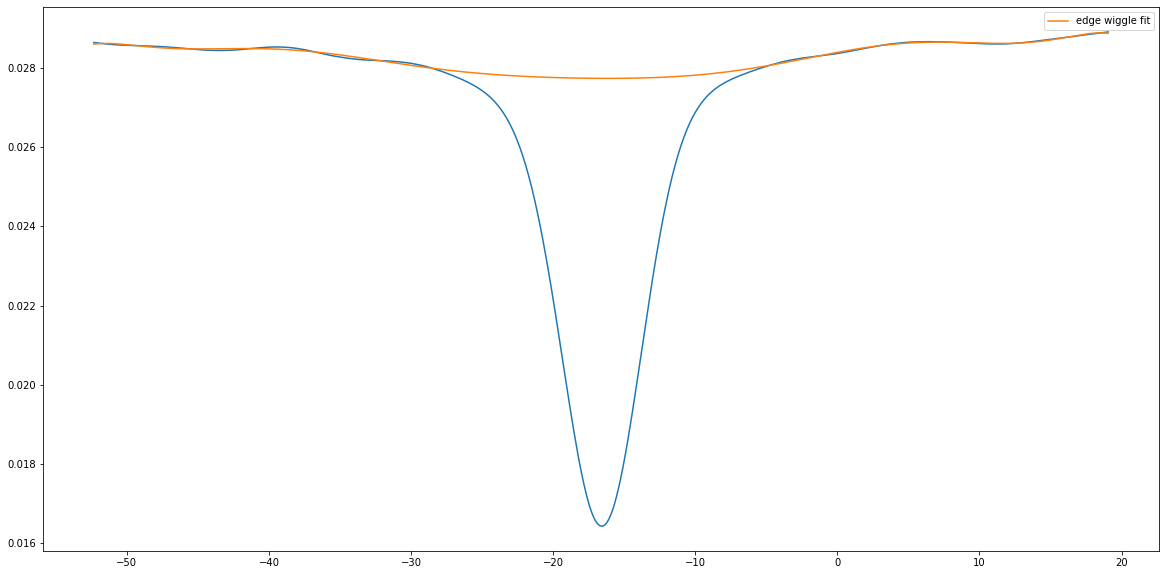

In [404]:
x_left = shifted_CCF_data[0:250]
rv_left = rv_data[0:250]
x_right = shifted_CCF_data[465:715]
rv_right = rv_data[465:715]
x_norm_range = list(x_left) + list(x_right)
rv_norm_range = list(rv_left) + list(rv_right)


z = np.polyfit(rv_norm_range,x_norm_range,10)
p = np.poly1d(z)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(rv_data, shifted_CCF_data)
#plt.plot(rv_norm_range, p(rv_norm_range))
plt.plot(rv_data, p(rv_data), label="edge wiggle fit")
#plt.plot(rv_data, gauss(rv_data,pfit), label="gauss quadratic fit")
plt.legend()

z

In [140]:
results["niter"]

7

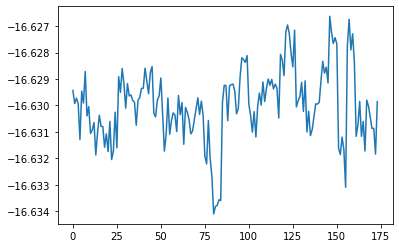

In [136]:
plt.plot(df_master["mu_zero_list"])

In [138]:
np.std(df_master["mu_zero_list"])*1000

1.3817337097441413